In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import os as os

path = "./results_TD3_15/"

The load_curves function loads the results of multiple algorithms across different environments from .npy files, stores them in a dictionary structure, and processes them to ensure the curves all have the same length.

In [2]:
def load_curves(algorithms, envs, t):
    curves = {alg: {e: [] for e in envs} for alg in algorithms} # create a dictionary 
    for alg in algorithms:
        for e in envs:
            for i in range(0, 100):
                if t == 0: name = f"{path}/{alg}_{e}_{i}.npy"
                if t == 1: name = f"{path}/{alg}_{e}_{i}_s.npy"
                
                if os.path.isfile(name):
                    #print(f"{name} loaded", np.load(name).shape)
                    curves[alg][e].append(list(np.load(name)))
            max_size = -1        
            for i in range(len(curves[alg][e])):
                if len(curves[alg][e][i]) > max_size:
                    max_size = len(curves[alg][e][i])
            for i in range(len(curves[alg][e])):
                while len(curves[alg][e][i]) <= max_size:
                    curves[alg][e][i].append(curves[alg][e][i][-1])

            curves[alg][e] = np.array(curves[alg][e]) if len(curves[alg][e]) else np.array([[]])
    
    return curves

The smooth function applies a smoothing technique to the loaded data by averaging over a window of neighboring points, creating a more visually appealing curve by reducing fluctuations.

In [3]:
def smooth(data, length=10):
    data = data.copy()
    pad = copy.deepcopy(data[:, -1, None].repeat(length-1, axis=-1)) # padding the data
    pad_data = np.concatenate((data, pad), axis=-1)
    pad = copy.deepcopy(data[:, 0, None].repeat(length-1, axis=-1))  # padding the data
    pad_data = np.concatenate((pad, pad_data), axis=-1)
    
    for i in range(length, len(data[0])+length):
        assert i-length >= 0
        data[:, i-length] = np.mean(pad_data[:, i-length:i+length], axis=-1) # smooth the data with its average
    return data

Plot the results

In [4]:
def plot_results(ENVS, ALGORITHMS, curves, use_median, sample_rates):
    """
    Plots the performance curves for different algorithms in various environments.
    Parameters:
    - ENVS: List of environment names.
    - ALGORITHMS: List of algorithm names.
    - curves: Dictionary of data for each algorithm and environment.
    - use_median: Boolean; if True, use median with quartiles; if False, use mean with std deviation.
    - sample_rates: Dictionary of sampling rates for each algorithm.
    """
    for e in ENVS:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.set_title(e) # Set environment name as the title
        ax.set_xlabel("Time [hours]") # Label for x-axis in hours
        ax.set_xlabel("Steps [1e4]") # Label for x-axis in steps
        ax.set_ylabel("Success rate" if use_median else "Reward") # Label for y-axis
        
        for i, alg in enumerate(ALGORITHMS):
            c = curves[alg][e] # Get data for the algorithm on this environment
            if c.size == 0:
                print(f"No data for {alg} on {e}. Skipping.")
                continue # Skip if there's no data
            
            # Compute the time axis based on the sampling rate
            x = np.arange(c.shape[1]) / sample_rates[alg]   # for hours
            x = np.arange(c.shape[1]) / 2                   # for steps
            
            if use_median:
                # Compute median, 1st quartile (25th percentile), and 3rd quartile (75th percentile)
                median = smooth(np.median(c, axis=0, keepdims=True), length=2).squeeze() # Smooth median
                q1 = smooth(np.percentile(c, 25, axis=0, keepdims=True), length=2).squeeze() # Smooth 25th percentile
                q3 = smooth(np.percentile(c, 75, axis=0, keepdims=True), length=2).squeeze() # Smooth 75th percentile
                ax.plot(x, median, label=alg, linewidth=4, linestyle='--', color='C' + str(i)) # Plot median curve
                ax.fill_between(x, q1, q3, alpha=0.2, color='C' + str(i)) # Fill between 1st and 3rd quartile
            else:
                # Compute mean and standard deviation
                mu = smooth(c.mean(axis=0, keepdims=True), length=2).squeeze() # Smooth mean
                sigma = smooth(c.std(axis=0, keepdims=True), length=2).squeeze() # Smooth std deviation
                ax.plot(x, mu, label=alg, linewidth=4, linestyle='--', color='C' + str(i)) # Plot mean curve
                ax.fill_between(x, mu + sigma, mu - sigma, alpha=0.2, color='C' + str(i)) # Fill between std deviation
        
            ax.set_xticks(np.arange(0, x[-1] + 1, step=1))      # for hours
            ax.set_xticks(np.arange(0, x[-1] + 1, step=10))     # for steps

        ax.grid(True)   # Add grid
        ax.legend()     # Add legend for algorithms
        # ax.set_xlim(0, 10)
        plt.show() # Show the plot

In [5]:
# Define environments and algorithms
ENVS = ['MR-env']
ALGORITHMS = ['OurDDPG', 'ExpD3', 'TD3', 'SAC']

sample_rates = {
    "OurDDPG": 10,  # 10 Hz
    "ExpD3": 15,    # 15 Hz
    "TD3": 8,       # 8 Hz
    "SAC": 5,       # 5 Hz
}

# ENVS = ['MR-env', 'MR-corridor-env']
# ALGORITHMS = ['OurDDPG', 'ExpD3', 'SAC']

Plots the performance curves for each algorithm on each environment.

No data for OurDDPG on MR-env. Skipping.
No data for ExpD3 on MR-env. Skipping.
No data for SAC on MR-env. Skipping.


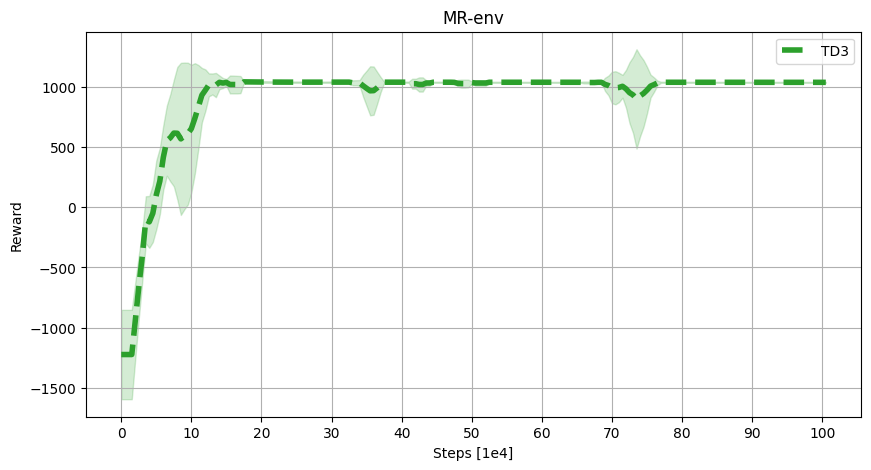

In [6]:
# Load the curves
curves = load_curves(ALGORITHMS, ENVS, t = 0)
# Plot data
plot_results(ENVS, ALGORITHMS, curves, False, sample_rates)

No data for OurDDPG on MR-env. Skipping.
No data for ExpD3 on MR-env. Skipping.
No data for SAC on MR-env. Skipping.


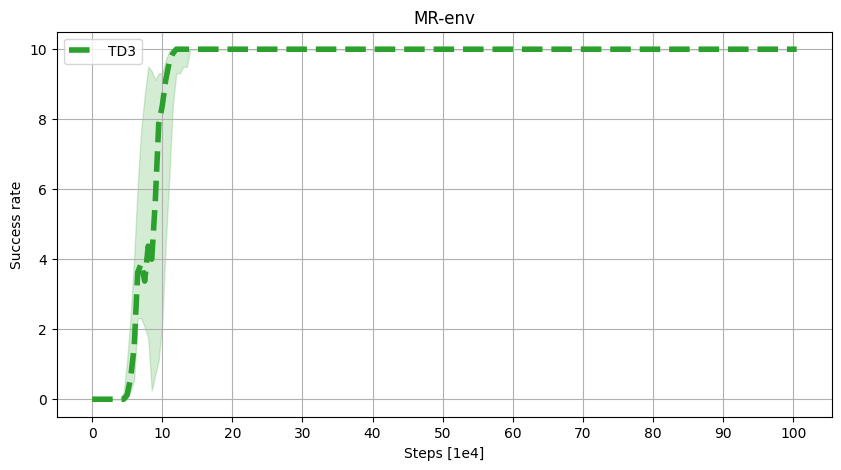

In [7]:
# Load the curves
curves = load_curves(ALGORITHMS, ENVS, t = 1)
# Plot data
plot_results(ENVS, ALGORITHMS, curves, True, sample_rates)

In [8]:
import glob

def calculate_mean_success_rate(file_pattern):
    # List all files that match the naming pattern
    file_paths = glob.glob(file_pattern)
    
    # Check if any files were found
    if not file_paths:
        print("No files found matching the pattern.")
        return None
    
    # Load each file and store the results in a list
    data = []
    for file_path in file_paths:
        s = np.load(file_path)
        data.append(s)
    
    # Convert the list to a NumPy array and compute the mean
    data = np.array(data)
    mean_success = np.mean(data)
    
    # Display the mean success rate as a percentage
    print(f"Average success rate during training over {len(file_paths)} seeds: {mean_success * 100:.3f} %")

# Example usage:
print("OurDDPG:")
calculate_mean_success_rate("./results/OurDDPG_MR-env_*_t.npy")
print("ExpD3:")
calculate_mean_success_rate("./results/ExpD3_MR-env_*_t.npy")
print("TD3:")
calculate_mean_success_rate("./results/TD3_MR-env_*_t.npy")
print("SAC:")
calculate_mean_success_rate("./results/SAC_MR-env_*_t.npy")

OurDDPG:
No files found matching the pattern.
ExpD3:
No files found matching the pattern.
TD3:
No files found matching the pattern.
SAC:
No files found matching the pattern.


Calculate the time needed to do the experiment, based on the graphs above.

In [9]:
# Constants
total_steps = 1_000_000               # Total steps the robot takes
steps_per_second = 15                 # Robot executes 15 steps per second
return_time = 3                       # Time taken to return to the initial position (in seconds)

# Time calculations per step
time_per_step = 1 / steps_per_second  # Time taken for one step

# Phase 1: First 300,000 steps with a return every 500 steps
phase1_steps = 300_000
phase1_return_interval = 500

# Number of returns in phase 1
phase1_returns = phase1_steps // phase1_return_interval

# Total time for phase 1
phase1_step_time = phase1_steps * time_per_step
phase1_return_time = phase1_returns * return_time
phase1_time = phase1_step_time + phase1_return_time

# Output phase 1 details
print("Phase 1:")
print(f"  Number of steps: {phase1_steps}")
print(f"  Time for steps (in h): {phase1_step_time / 3600:.1f}")
print(f"  Number of returns: {phase1_returns}")
print(f"  Time for returns (in min): {phase1_return_time / 60:.0f}")
print(f"  Total time for phase 1 (in h): {phase1_time / 3600:.1f}\n")

# Phase 2: Remaining 700,000 steps with a return every 200 steps
phase2_steps = total_steps - phase1_steps
phase2_return_interval = 200

# Number of returns in phase 2
phase2_returns = phase2_steps // phase2_return_interval

# Total time for phase 2
phase2_step_time = phase2_steps * time_per_step
phase2_return_time = phase2_returns * return_time
phase2_time = phase2_step_time + phase2_return_time

# Output phase 2 details
print("Phase 2:")
print(f"  Number of steps: {phase2_steps}")
print(f"  Time for steps (in h): {phase2_step_time / 3600:.1f}")
print(f"  Number of returns: {phase2_returns}")
print(f"  Time for returns (in h): {phase2_return_time / 3600:.1f}")
print(f"  Total time for phase 2 (in h): {phase2_time / 3600:.1f}\n")

# Total time required
total_time = phase1_time + phase2_time

# Output the final result
print("Overall Results:")
print(f"  Total time required (in seconds): {total_time:.0f}")
print(f"  Total time required (in hours): {total_time / 3600:.1f}")


Phase 1:
  Number of steps: 300000
  Time for steps (in h): 5.6
  Number of returns: 600
  Time for returns (in min): 30
  Total time for phase 1 (in h): 6.1

Phase 2:
  Number of steps: 700000
  Time for steps (in h): 13.0
  Number of returns: 3500
  Time for returns (in h): 2.9
  Total time for phase 2 (in h): 15.9

Overall Results:
  Total time required (in seconds): 78967
  Total time required (in hours): 21.9
